In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Flatten, Conv2D, Dropout, 
                          MaxPooling2D, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

data = pd.read_csv("train.csv")

#convert to array and scale to 0-1
xarray = data.values[:,2:]/255

#reshape array to an array of images (#samples,28,28,1)
x = xarray.reshape(data.shape[0], 28, 28, 1)

#convert labels to one-hot vector
y = to_categorical(data.Label, 5)

#Define arquitecture
model = Sequential()
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same',
                 input_shape=(28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same' ))
model.add(Dropout(0.3))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same' ))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))

optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )

model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy", metrics=["accuracy"])

reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

checkpointer = ModelCheckpoint(filepath="fashion_mnist_model.h5",
                               verbose=1, save_best_only=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05,
                                                    random_state=42)

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=42,
          validation_data = (x_test, y_test),
          callbacks = [reduce_lr,checkpointer],
          verbose=1)

Epoch 1/42
223/223 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7538
Epoch 00001: val_loss improved from inf to 2.17288, saving model to fashion_mnist_model.h5
223/223 [==============================] - 22s 98ms/step - loss: 0.6586 - accuracy: 0.7538 - val_loss: 2.1729 - val_accuracy: 0.1897 - lr: 0.0010
Epoch 2/42
223/223 [==============================] - ETA: 0s - loss: 0.4599 - accuracy: 0.8187
Epoch 00002: val_loss improved from 2.17288 to 1.17455, saving model to fashion_mnist_model.h5
223/223 [==============================] - 20s 90ms/step - loss: 0.4599 - accuracy: 0.8187 - val_loss: 1.1745 - val_accuracy: 0.4723 - lr: 9.0000e-04
Epoch 3/42
223/223 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.8382
Epoch 00003: val_loss improved from 1.17455 to 0.39836, saving model to fashion_mnist_model.h5
223/223 [==============================] - 20s 91ms/step - loss: 0.4074 - accuracy: 0.8382 - val_loss: 0.3984 - val_accuracy: 0.8333 - 

In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 128)       1280      
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
batch_normalization_7 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 256)      

In [3]:
model.evaluate(x_test, y_test)

94/94 [==============================] - 1s 6ms/step - loss: 0.1959 - accuracy: 0.9233


[0.19591128826141357, 0.9233333468437195]

In [10]:
#load best model from checkpointer (Epoch 38)
from tensorflow.keras.models import load_model
best_model = load_model('fashion_mnist_model.h5')
best_model.evaluate(x_test, y_test)

94/94 [==============================] - 1s 6ms/step - loss: 0.1850 - accuracy: 0.9300


[0.18498501181602478, 0.9300000071525574]

In [0]:
#Predict Test Labels for Kaggle
dataset2 = pd.read_csv("./testX.csv")
xarray2 = dataset2.values[:,1:]/255
x2 = xarray2.reshape(dataset2.shape[0], 28, 28, 1)
Y_pred = best_model.predict(x2)
#Convert from one-hot vector 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

In [0]:
#save to csv file with specific format
DF = pd.DataFrame(dataset2.loc[:,"Id"])
DF["Label"]= Y_pred_classes
DF = DF.drop(columns=["Id"])
DF.index.name = "Id"
DF.to_csv('fincnn5.csv')

In [0]:
DF.to_csv('fincnn6.csv')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


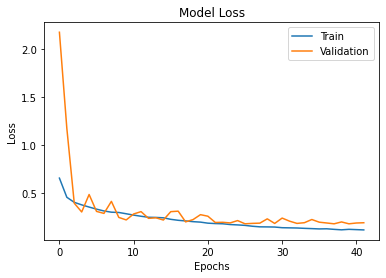

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

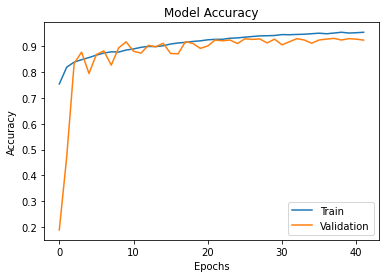

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

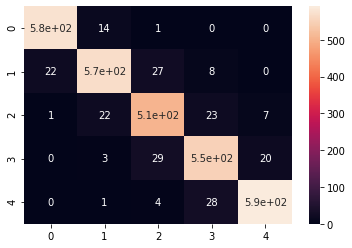

In [20]:
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = best_model.predict(x_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
sns.heatmap(confusion_mtx, annot=True)

This ROC plot was implemented as in :

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


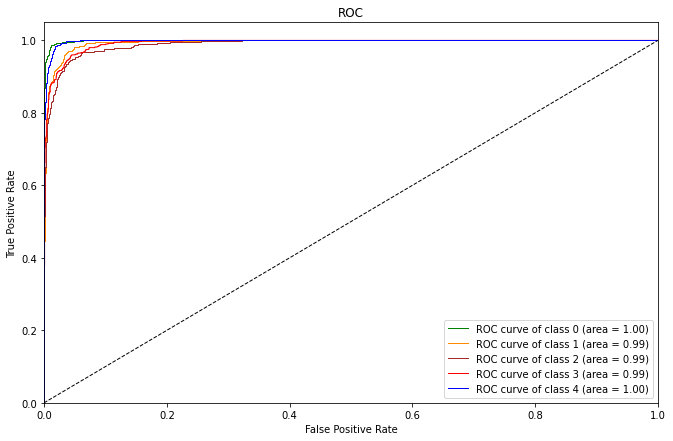

In [49]:
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = 5

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), Y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(11,7))

colors = cycle(['green', 'darkorange', 'brown','red','blue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [48]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       590
           1       0.93      0.91      0.92       625
           2       0.89      0.91      0.90       559
           3       0.90      0.91      0.91       602
           4       0.96      0.95      0.95       624

    accuracy                           0.93      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.93      0.93      0.93      3000

